In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from transformers import Dinov2Model



/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# project_dir = '/Users/k.choi/Documents/github/csiro_git'
project_dir = '/Users/kaheichoi/git_repo/csiro_biomass'
data_dir  = os.path.join(project_dir, 'data')
model_dir = os.path.join(project_dir, 'models')

train_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))
device    = torch.device('mps')

In [3]:
unique_paths  = train_csv['image_path'].unique(); print(unique_paths.shape)

(357,)


In [4]:
train_csv['target_name'].unique()

array(['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g',
       'GDM_g'], dtype=object)

In [5]:
def data_preprocess(df, data_dir):
    data_list = []
    
    unique_paths = df['image_path'].unique()
    target_names = df['target_name'].unique()

    for paths in unique_paths:
        data = df[ df['image_path'] == paths ]
        row = { 'image_path': paths }
        for tar in target_names:
            row[tar] = data[ data['target_name'] == tar ]['target'].values[0]
        
        data_list.append(row)

    return pd.DataFrame(data_list)

data_df = data_preprocess(train_csv, data_dir); display(data_df)


,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...
352,train/ID975115267.jpg,40.0300,0.0000,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,24.6445,4.1948,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,0.0000,1.1457,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,32.3575,0.0000,2.0325,34.3900,34.3900


In [6]:
train_data, test_data  = train_test_split(data_df, test_size=0.01, random_state=8964); print(f'train: {len(train_data)}, test: {len(test_data)}')

train: 353, test: 4


In [7]:
def create_stratified_folds(df, target_col='Dry_Total_g', n_folds=5, random_state=8964):
    strata_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
 
    bins = [0, 20, 40, 60, 80, np.inf]
    dfcopy = df.copy()
    dfcopy['strata'] = pd.cut(dfcopy[target_col], bins=bins, labels=False) 
    
    kfolds = []
    for train_idx, val_idx in strata_kfold.split(dfcopy, dfcopy['strata']):
        kfolds.append((train_idx, val_idx))
    
    return kfolds

kfolds  = create_stratified_folds(train_data, target_col='Dry_Total_g', n_folds=5)

for i, (train_idx, val_idx) in enumerate(kfolds): 
    print(f"Fold {i+1}: {len(train_idx)} train, {len(val_idx)} val")
    assert len(train_idx) + len(val_idx) == len(train_data)

Fold 1: 282 train, 71 val
Fold 2: 282 train, 71 val
Fold 3: 282 train, 71 val
Fold 4: 283 train, 70 val
Fold 5: 283 train, 70 val


In [8]:
class tta:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std 

    def get_transforms(self):
        return [
            ( 'id',     self.__get_id()),
            ( 'hflip',  self.__get_hflip()),
            ( 'vflip',  self.__get_vflip()),
            ( 'rot90',  self.__get_rota(90)),
            ( 'rot180', self.__get_rota(180)),
            ( 'rot270', self.__get_rota(270)) ]

    def __get_id(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_hflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_vflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomVerticalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
        
    def __get_rota(self,angle):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Lambda(lambda img: transforms.functional.rotate(img, angle)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
         

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]  

tta_transforms = tta(mean=mean, std=std)
tta_list = tta_transforms.get_transforms()

for names, _ in tta_list: print(names)

id
hflip
vflip
rot90
rot180
rot270


In [9]:
class random_tranfo:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def get_transfo(self):
        return [ self.train_transform(), self.valid_transform() ]
        
    ### no rota because no differences
    def train_transform(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
    
    def valid_transform(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
     

rand_transfo = random_tranfo(mean=mean, std=std)
train_transfo, valid_transfo = rand_transfo.get_transfo()


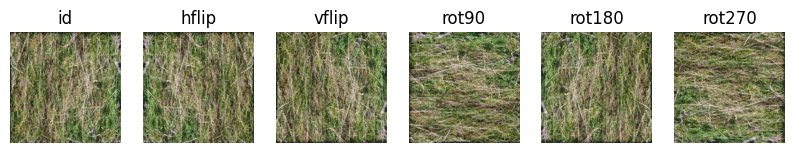

In [10]:
img_path = os.path.join( data_dir, np.random.choice(unique_paths)) 

fig,axes = plt.subplots(1,6, figsize=(10,3))
for i, (name, transform) in enumerate(tta_list):
    img = Image.open(img_path)
    img = transform(img)
    
    mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
    std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)

    img  = img * std + mean
    img  = torch.clamp(img,0,1)
    img  = img.permute(1,2,0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.show()

In [11]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return img, targets

In [12]:
# class TTABiomassDS(Dataset):
#     def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
#         self.df = df.reset_index(drop=True)
#         self.data_dir = data_dir
#         self.transform = transform
#         self.target_names = target_names

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         img = Image.open(os.path.join(self.data_dir, row['image_path'])).convert('RGB')


In [13]:
class call_my_dino(nn.Module):
    def __init__(self, backbone, patch_dim, n_targets):
        super().__init__()
        
        self.backbone = backbone
        for params in self.backbone.parameters():
            params.requires_grad = False

        self.dino_head = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, n_targets),
        )

    def forward(self, x):
        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :]

        batch_size, n_patches, patch_dim = patch_features.shape
        patch_features_flat = patch_features.reshape(-1, patch_dim)
        patch_pred = self.dino_head(patch_features_flat)
        patch_pred = patch_pred.reshape(batch_size, n_patches, -1)

        final_pred = torch.mean(patch_pred, dim=1)

        return final_pred, patch_pred

In [14]:
small_dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small');
small_dinov2_backbone.eval();
small_dinov2_backbone.to(device);

In [15]:
# dino_model = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)

# dino_model.load_state_dict(torch.load(os.path.join(model_dir, 'dino_model_small.pth')))
# dino_model.to(device)
# dino_model.eval()

In [16]:
from sklearn.metrics import mean_squared_error

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss , batch = 0 , 0 

    pbar = tqdm(train_loader, desc='Training')
    for img, tar in pbar:
        img, tar = img.to(device), tar.to(device)

        optimizer.zero_grad()
        pred, _ = model(img)
        loss = criterion(pred, tar)

        loss.backward(); optimizer.step()
        total_loss += loss.item(); batch += 1 
    return total_loss / batch

def valid_epoch(model, valid_loader, criterion, device):
    model.eval()
    total_loss , batch = 0 , 0 

    all_pred, all_tar = [], []
    with torch.no_grad():

        pbar = tqdm(valid_loader, desc='Validation')
        for img, tar in pbar:
            img, tar = img.to(device), tar.to(device)
            
            pred, _ = model(img)
            loss    = criterion(pred, tar)

            total_loss += loss.item(); batch += 1

            all_pred.append(pred.cpu()); all_tar.append(tar.cpu())

    all_pred = torch.cat(all_pred).numpy()
    all_tar  = torch.cat(all_tar).numpy()

    avg_loss = total_loss / batch
    rmse     = np.sqrt(mean_squared_error(all_pred, all_tar))

    return avg_loss, rmse

In [17]:
MAX_EPOCHS = 120

LR = 1e-3
WEIGHT_DECAY = 1e-4
LR_PATIENCE = 5
PATIENCE = 10

batch_size  = 16

criterion = nn.MSELoss()

fold_model, fold_history, fold_best_rmses = [], [], []


for fold_idx, (train_idx, val_idx) in enumerate(kfolds):

    train_fold = train_data.iloc[train_idx]
    valid_fold = train_data.iloc[val_idx]

    print(f'Fold {fold_idx+1} : {len(train_idx)} train, {len(val_idx)} val')

    train_ds     = BiomassDS(df =train_fold, data_dir =data_dir, transform = train_transfo)
    valid_ds     = BiomassDS(df =valid_fold, data_dir =data_dir, transform = valid_transfo)
    
    train_loader = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size= batch_size, shuffle=False)
 
    print('Dataloader completed')
    model = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)
    model.to(device)

    print('Dino has been summoned')
 
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience= LR_PATIENCE)
 
    print('Optimizer has arrived so as the scheduler')
    print(' ==' * 32)

    history = {'train_loss':[], 'valid_loss':[], 'rmse':[], 'learning_rate':[]}
    best_val, best_rmse, best_epoch, epoch_counter, best_model = np.inf,0,0,0, None

    for epoch in range(MAX_EPOCHS):

        print(f'Epoch {epoch+1} / {MAX_EPOCHS}')
        print(' -' * 32)
        epoch_counter += 1

        train_loss              = train_epoch(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_rmse  = valid_epoch(model, valid_loader, criterion, device)
        
        scheduler.step(valid_loss)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['rmse'].append(valid_rmse)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}, Valid RMSE: {valid_rmse:.4f}')
        if valid_loss < best_val:
            best_val  = valid_loss
            best_rmse = valid_rmse
            best_epoch = epoch
            best_model = model.state_dict()

            torch.save(best_model, os.path.join(model_dir, f'best_model_fold_{fold_idx}.pth'))
            epoch_counter = 0

            print(f'New best model at epoch {best_epoch} with val_loss {best_val}')
        else:
            print(f'no improvement since epoch {best_epoch} with val_loss {best_val}')
            epoch_counter += 1
        
        if epoch_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch_counter}, best model at epoch {best_epoch}')
            break

    fold_history.append(history) 
    fold_model.append(best_model) 
    fold_best_rmses.append(best_rmse)

    torch.mps.empty_cache()
    

Fold 1 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 1150.4524, Valid loss: 896.4150, Valid RMSE: 31.0759
New best model at epoch 0 with val_loss 896.4150451660156
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 1024.7161, Valid loss: 803.3592, Valid RMSE: 29.4598
New best model at epoch 1 with val_loss 803.3591735839843
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Train loss: 936.2874, Valid loss: 717.2849, Valid RMSE: 27.8679
New best model at epoch 2 with val_loss 717.284878540039
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 854.0006, Valid loss: 646.1974, Valid RMSE: 26.4672
New best model at epoch 3 with val_loss 646.1973541259765
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Train loss: 753.9119, Valid loss: 583.4084, Valid RMSE: 25.1491
New best model at epoch 4 with val_loss 583.408413696289
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 695.6677, Valid loss: 535.9850, Valid RMSE: 24.0909
New best model at epoch 5 with val_loss 535.984976196289
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 636.7440, Valid loss: 497.8813, Valid RMSE: 23.1968
New best model at epoch 6 with val_loss 497.8812652587891
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 597.1891, Valid loss: 459.8868, Valid RMSE: 22.3250
New best model at epoch 7 with val_loss 459.88677673339845
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 538.3972, Valid loss: 424.5241, Valid RMSE: 21.4514
New best model at epoch 8 with val_loss 424.5240997314453
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 497.1541, Valid loss: 394.9805, Valid RMSE: 20.6634
New best model at epoch 9 with val_loss 394.9805480957031
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 464.0554, Valid loss: 378.0255, Valid RMSE: 20.1559
New best model at epoch 10 with val_loss 378.0255157470703
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Train loss: 435.2641, Valid loss: 348.4815, Valid RMSE: 19.3232
New best model at epoch 11 with val_loss 348.48150024414065
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Train loss: 395.5194, Valid loss: 321.0591, Valid RMSE: 18.5350
New best model at epoch 12 with val_loss 321.0591186523437
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 371.1749, Valid loss: 304.4944, Valid RMSE: 17.9717
New best model at epoch 13 with val_loss 304.4944183349609
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 343.8822, Valid loss: 295.7482, Valid RMSE: 17.6869
New best model at epoch 14 with val_loss 295.7481628417969
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 327.3795, Valid loss: 276.1506, Valid RMSE: 17.0870
New best model at epoch 15 with val_loss 276.1505889892578
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 304.6403, Valid loss: 268.6453, Valid RMSE: 16.7532
New best model at epoch 16 with val_loss 268.6453063964844
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 291.9114, Valid loss: 252.8899, Valid RMSE: 16.2073
New best model at epoch 17 with val_loss 252.88989868164063
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 269.7031, Valid loss: 235.7085, Valid RMSE: 15.6666
New best model at epoch 18 with val_loss 235.70853576660156
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 254.2225, Valid loss: 232.9015, Valid RMSE: 15.5061
New best model at epoch 19 with val_loss 232.90146179199218
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 250.8219, Valid loss: 218.1999, Valid RMSE: 15.0308
New best model at epoch 20 with val_loss 218.19988708496095
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 230.8779, Valid loss: 208.9404, Valid RMSE: 14.6469
New best model at epoch 21 with val_loss 208.94044189453126
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 215.1624, Valid loss: 212.3782, Valid RMSE: 14.6705
no improvement since epoch 21 with val_loss 208.94044189453126
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 202.7547, Valid loss: 197.1738, Valid RMSE: 14.1294
New best model at epoch 23 with val_loss 197.1738052368164
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 191.9701, Valid loss: 195.0367, Valid RMSE: 14.0552
New best model at epoch 24 with val_loss 195.03665313720703
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 179.9962, Valid loss: 189.1979, Valid RMSE: 13.7648
New best model at epoch 25 with val_loss 189.19793243408202
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 175.4755, Valid loss: 181.7848, Valid RMSE: 13.4486
New best model at epoch 26 with val_loss 181.78475646972657
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 164.6077, Valid loss: 174.0125, Valid RMSE: 13.0963
New best model at epoch 27 with val_loss 174.0124984741211
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 156.7132, Valid loss: 167.5783, Valid RMSE: 12.9057
New best model at epoch 28 with val_loss 167.5783248901367
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 146.8634, Valid loss: 171.2014, Valid RMSE: 13.0970
no improvement since epoch 28 with val_loss 167.5783248901367
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 137.5141, Valid loss: 161.8722, Valid RMSE: 12.6313
New best model at epoch 30 with val_loss 161.87220458984376
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 134.6353, Valid loss: 158.5753, Valid RMSE: 12.4836
New best model at epoch 31 with val_loss 158.57533111572266
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 125.5604, Valid loss: 151.4606, Valid RMSE: 12.2813
New best model at epoch 32 with val_loss 151.46063079833985
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 123.3848, Valid loss: 161.7069, Valid RMSE: 12.5439
no improvement since epoch 32 with val_loss 151.46063079833985
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 124.6327, Valid loss: 146.1845, Valid RMSE: 11.9625
New best model at epoch 34 with val_loss 146.18453063964844
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 111.0131, Valid loss: 146.2847, Valid RMSE: 11.9669
no improvement since epoch 34 with val_loss 146.18453063964844
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 108.0591, Valid loss: 139.4315, Valid RMSE: 11.6501
New best model at epoch 36 with val_loss 139.43152618408203
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 104.3674, Valid loss: 142.2772, Valid RMSE: 11.6890
no improvement since epoch 36 with val_loss 139.43152618408203
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 95.2168, Valid loss: 136.6882, Valid RMSE: 11.4976
New best model at epoch 38 with val_loss 136.68821563720704
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss: 88.0703, Valid loss: 137.9510, Valid RMSE: 11.4907
no improvement since epoch 38 with val_loss 136.68821563720704
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 82.7271, Valid loss: 136.2952, Valid RMSE: 11.4264
New best model at epoch 40 with val_loss 136.29523315429688
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 78.6610, Valid loss: 137.3999, Valid RMSE: 11.4944
no improvement since epoch 40 with val_loss 136.29523315429688
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 75.9836, Valid loss: 134.7591, Valid RMSE: 11.3637
New best model at epoch 42 with val_loss 134.7591293334961
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 72.7332, Valid loss: 132.2601, Valid RMSE: 11.2979
New best model at epoch 43 with val_loss 132.26006622314452
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 69.2100, Valid loss: 137.0347, Valid RMSE: 11.4507
no improvement since epoch 43 with val_loss 132.26006622314452
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 67.2608, Valid loss: 144.5724, Valid RMSE: 11.7788
no improvement since epoch 43 with val_loss 132.26006622314452
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Train loss: 68.1244, Valid loss: 133.0563, Valid RMSE: 11.2562
no improvement since epoch 43 with val_loss 132.26006622314452
Epoch 48 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 61.2676, Valid loss: 123.9429, Valid RMSE: 10.8660
New best model at epoch 47 with val_loss 123.94287719726563
Epoch 49 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Train loss: 59.1764, Valid loss: 134.5076, Valid RMSE: 11.4010
no improvement since epoch 47 with val_loss 123.94287719726563
Epoch 50 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train loss: 61.2569, Valid loss: 139.0801, Valid RMSE: 11.4672
no improvement since epoch 47 with val_loss 123.94287719726563
Epoch 51 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 60.4506, Valid loss: 139.4293, Valid RMSE: 11.4199
no improvement since epoch 47 with val_loss 123.94287719726563
Epoch 52 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 55.9339, Valid loss: 143.4846, Valid RMSE: 11.6303
no improvement since epoch 47 with val_loss 123.94287719726563
Epoch 53 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Train loss: 55.1161, Valid loss: 135.3197, Valid RMSE: 11.3828
no improvement since epoch 47 with val_loss 123.94287719726563
Early stopping at epoch 10, best model at epoch 47
Fold 2 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Train loss: 1075.8473, Valid loss: 1223.7654, Valid RMSE: 35.6305
New best model at epoch 0 with val_loss 1223.7653564453126
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 980.0719, Valid loss: 1118.4490, Valid RMSE: 34.1065
New best model at epoch 1 with val_loss 1118.448974609375
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 869.9130, Valid loss: 1018.4864, Valid RMSE: 32.5916
New best model at epoch 2 with val_loss 1018.4863891601562
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 776.0062, Valid loss: 925.9039, Valid RMSE: 31.1203
New best model at epoch 3 with val_loss 925.903857421875
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 715.9368, Valid loss: 849.4955, Valid RMSE: 29.8482
New best model at epoch 4 with val_loss 849.4954956054687
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 631.3606, Valid loss: 781.5625, Valid RMSE: 28.6671
New best model at epoch 5 with val_loss 781.5625183105469
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 570.6761, Valid loss: 721.8091, Valid RMSE: 27.5793
New best model at epoch 6 with val_loss 721.809130859375
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 527.7444, Valid loss: 664.3723, Valid RMSE: 26.4981
New best model at epoch 7 with val_loss 664.3723327636719
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 479.9877, Valid loss: 616.2445, Valid RMSE: 25.5574
New best model at epoch 8 with val_loss 616.2444793701172
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Train loss: 438.8443, Valid loss: 573.6330, Valid RMSE: 24.7020
New best model at epoch 9 with val_loss 573.6329986572266
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 411.6093, Valid loss: 534.0993, Valid RMSE: 23.8648
New best model at epoch 10 with val_loss 534.0993255615234
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 370.8085, Valid loss: 500.9040, Valid RMSE: 23.1293
New best model at epoch 11 with val_loss 500.90399780273435
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 349.3361, Valid loss: 474.8238, Valid RMSE: 22.5396
New best model at epoch 12 with val_loss 474.8237823486328
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 329.7070, Valid loss: 450.2992, Valid RMSE: 21.9613
New best model at epoch 13 with val_loss 450.2992431640625
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 311.1589, Valid loss: 429.0775, Valid RMSE: 21.4338
New best model at epoch 14 with val_loss 429.0774978637695
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 281.7240, Valid loss: 403.5037, Valid RMSE: 20.8000
New best model at epoch 15 with val_loss 403.5036911010742
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Train loss: 271.6399, Valid loss: 393.8488, Valid RMSE: 20.5866
New best model at epoch 16 with val_loss 393.8488250732422
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 250.1601, Valid loss: 370.4632, Valid RMSE: 19.9547
New best model at epoch 17 with val_loss 370.4631866455078
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 231.7598, Valid loss: 360.8488, Valid RMSE: 19.7328
New best model at epoch 18 with val_loss 360.84878997802736
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Train loss: 215.3788, Valid loss: 342.0811, Valid RMSE: 19.1944
New best model at epoch 19 with val_loss 342.08108978271486
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 205.3823, Valid loss: 329.7370, Valid RMSE: 18.8283
New best model at epoch 20 with val_loss 329.73697967529296
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 186.6514, Valid loss: 317.3422, Valid RMSE: 18.4860
New best model at epoch 21 with val_loss 317.3422164916992
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 175.0434, Valid loss: 313.6547, Valid RMSE: 18.3978
New best model at epoch 22 with val_loss 313.6546875
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 165.4553, Valid loss: 310.6862, Valid RMSE: 18.3569
New best model at epoch 23 with val_loss 310.6861602783203
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 161.4660, Valid loss: 299.4856, Valid RMSE: 18.0076
New best model at epoch 24 with val_loss 299.48557434082034
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 146.1142, Valid loss: 291.2466, Valid RMSE: 17.7565
New best model at epoch 25 with val_loss 291.2466110229492
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 138.0028, Valid loss: 279.2435, Valid RMSE: 17.3580
New best model at epoch 26 with val_loss 279.2434875488281
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Train loss: 127.4593, Valid loss: 282.9419, Valid RMSE: 17.4446
no improvement since epoch 26 with val_loss 279.2434875488281
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 120.0488, Valid loss: 273.0329, Valid RMSE: 17.1626
New best model at epoch 28 with val_loss 273.0329086303711
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 117.3497, Valid loss: 263.3387, Valid RMSE: 16.8662
New best model at epoch 29 with val_loss 263.3386993408203
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 112.0386, Valid loss: 269.8070, Valid RMSE: 17.0786
no improvement since epoch 29 with val_loss 263.3386993408203
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 102.5276, Valid loss: 253.8803, Valid RMSE: 16.5290
New best model at epoch 31 with val_loss 253.8802734375
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Train loss: 98.8055, Valid loss: 255.3383, Valid RMSE: 16.5483
no improvement since epoch 31 with val_loss 253.8802734375
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 93.4770, Valid loss: 243.2535, Valid RMSE: 16.1661
New best model at epoch 33 with val_loss 243.25350646972657
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 88.4313, Valid loss: 234.9196, Valid RMSE: 15.9104
New best model at epoch 34 with val_loss 234.91956176757813
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Train loss: 81.9286, Valid loss: 227.5768, Valid RMSE: 15.6648
New best model at epoch 35 with val_loss 227.57677764892577
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 80.6034, Valid loss: 222.8631, Valid RMSE: 15.5128
New best model at epoch 36 with val_loss 222.86312866210938
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 80.2057, Valid loss: 223.0319, Valid RMSE: 15.3876
no improvement since epoch 36 with val_loss 222.86312866210938
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 76.3352, Valid loss: 230.1523, Valid RMSE: 15.6769
no improvement since epoch 36 with val_loss 222.86312866210938
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 65.9882, Valid loss: 229.9272, Valid RMSE: 15.5891
no improvement since epoch 36 with val_loss 222.86312866210938
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 64.7624, Valid loss: 222.7489, Valid RMSE: 15.3812
New best model at epoch 40 with val_loss 222.7489273071289
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 63.4767, Valid loss: 213.8529, Valid RMSE: 15.1412
New best model at epoch 41 with val_loss 213.85287017822264
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Train loss: 60.0715, Valid loss: 215.4677, Valid RMSE: 15.2456
no improvement since epoch 41 with val_loss 213.85287017822264
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Train loss: 55.9157, Valid loss: 214.3370, Valid RMSE: 15.2180
no improvement since epoch 41 with val_loss 213.85287017822264
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 56.9312, Valid loss: 204.7828, Valid RMSE: 14.8342
New best model at epoch 44 with val_loss 204.78277282714845
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 52.4102, Valid loss: 207.5518, Valid RMSE: 14.9218
no improvement since epoch 44 with val_loss 204.78277282714845
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 48.8759, Valid loss: 195.8255, Valid RMSE: 14.5833
New best model at epoch 46 with val_loss 195.82550354003905
Epoch 48 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 45.2818, Valid loss: 196.8456, Valid RMSE: 14.5588
no improvement since epoch 46 with val_loss 195.82550354003905
Epoch 49 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 46.0410, Valid loss: 205.1104, Valid RMSE: 14.8750
no improvement since epoch 46 with val_loss 195.82550354003905
Epoch 50 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 44.6576, Valid loss: 194.4567, Valid RMSE: 14.5022
New best model at epoch 49 with val_loss 194.4566864013672
Epoch 51 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Train loss: 46.1377, Valid loss: 190.6247, Valid RMSE: 14.2950
New best model at epoch 50 with val_loss 190.62466278076172
Epoch 52 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 43.0346, Valid loss: 185.8400, Valid RMSE: 14.1524
New best model at epoch 51 with val_loss 185.83999938964843
Epoch 53 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 37.8962, Valid loss: 197.8139, Valid RMSE: 14.5742
no improvement since epoch 51 with val_loss 185.83999938964843
Epoch 54 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 35.8856, Valid loss: 186.7829, Valid RMSE: 14.1744
no improvement since epoch 51 with val_loss 185.83999938964843
Epoch 55 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 34.7186, Valid loss: 185.9574, Valid RMSE: 14.1975
no improvement since epoch 51 with val_loss 185.83999938964843
Epoch 56 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 31.1702, Valid loss: 185.3610, Valid RMSE: 14.1115
New best model at epoch 55 with val_loss 185.36095275878907
Epoch 57 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 32.8310, Valid loss: 193.0175, Valid RMSE: 14.4636
no improvement since epoch 55 with val_loss 185.36095275878907
Epoch 58 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 33.8531, Valid loss: 172.5099, Valid RMSE: 13.6115
New best model at epoch 57 with val_loss 172.5098663330078
Epoch 59 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 28.2582, Valid loss: 181.8669, Valid RMSE: 14.0179
no improvement since epoch 57 with val_loss 172.5098663330078
Epoch 60 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 27.5385, Valid loss: 180.2211, Valid RMSE: 13.9889
no improvement since epoch 57 with val_loss 172.5098663330078
Epoch 61 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 25.3241, Valid loss: 173.7555, Valid RMSE: 13.6797
no improvement since epoch 57 with val_loss 172.5098663330078
Epoch 62 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 26.7673, Valid loss: 181.9660, Valid RMSE: 14.0620
no improvement since epoch 57 with val_loss 172.5098663330078
Epoch 63 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 27.7742, Valid loss: 181.7083, Valid RMSE: 13.9812
no improvement since epoch 57 with val_loss 172.5098663330078
Early stopping at epoch 10, best model at epoch 57
Fold 3 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 1109.3279, Valid loss: 1318.3501, Valid RMSE: 33.3140
New best model at epoch 0 with val_loss 1318.35009765625
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 1030.4312, Valid loss: 1201.7584, Valid RMSE: 31.6803
New best model at epoch 1 with val_loss 1201.7583618164062
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 916.4465, Valid loss: 1091.1878, Valid RMSE: 30.0669
New best model at epoch 2 with val_loss 1091.1878173828125
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 808.6202, Valid loss: 990.2785, Valid RMSE: 28.5339
New best model at epoch 3 with val_loss 990.278515625
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Train loss: 746.0991, Valid loss: 900.4281, Valid RMSE: 27.1170
New best model at epoch 4 with val_loss 900.4281311035156
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 682.5122, Valid loss: 823.7978, Valid RMSE: 25.8660
New best model at epoch 5 with val_loss 823.7978210449219
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 601.0094, Valid loss: 752.9974, Valid RMSE: 24.6522
New best model at epoch 6 with val_loss 752.9973754882812
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 550.7672, Valid loss: 690.2547, Valid RMSE: 23.5344
New best model at epoch 7 with val_loss 690.2546630859375
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 506.0847, Valid loss: 635.7289, Valid RMSE: 22.5391
New best model at epoch 8 with val_loss 635.7288879394531
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 470.2875, Valid loss: 588.9590, Valid RMSE: 21.6584
New best model at epoch 9 with val_loss 588.9589691162109
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 433.8412, Valid loss: 547.0627, Valid RMSE: 20.8389
New best model at epoch 10 with val_loss 547.0627319335938
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 403.6232, Valid loss: 510.3832, Valid RMSE: 20.1230
New best model at epoch 11 with val_loss 510.3832061767578
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 376.0880, Valid loss: 473.1990, Valid RMSE: 19.3221
New best model at epoch 12 with val_loss 473.19903259277345
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 351.4164, Valid loss: 455.1606, Valid RMSE: 19.0199
New best model at epoch 13 with val_loss 455.1606109619141
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 326.7590, Valid loss: 420.5839, Valid RMSE: 18.2135
New best model at epoch 14 with val_loss 420.5838989257812
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 304.5662, Valid loss: 390.5042, Valid RMSE: 17.4921
New best model at epoch 15 with val_loss 390.50421142578125
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 290.8187, Valid loss: 372.8874, Valid RMSE: 17.1171
New best model at epoch 16 with val_loss 372.8874450683594
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 276.1818, Valid loss: 356.6959, Valid RMSE: 16.7875
New best model at epoch 17 with val_loss 356.6958801269531
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 268.9847, Valid loss: 334.4180, Valid RMSE: 16.1893
New best model at epoch 18 with val_loss 334.4180389404297
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 238.7356, Valid loss: 315.3887, Valid RMSE: 15.7294
New best model at epoch 19 with val_loss 315.38870391845705
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 228.6324, Valid loss: 307.2919, Valid RMSE: 15.5755
New best model at epoch 20 with val_loss 307.29190521240236
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 214.7243, Valid loss: 291.9416, Valid RMSE: 15.1421
New best model at epoch 21 with val_loss 291.941584777832
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 201.7400, Valid loss: 278.1735, Valid RMSE: 14.8000
New best model at epoch 22 with val_loss 278.1734893798828
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 200.5365, Valid loss: 263.4978, Valid RMSE: 14.3249
New best model at epoch 23 with val_loss 263.4977630615234
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 179.8668, Valid loss: 263.5978, Valid RMSE: 14.4867
no improvement since epoch 23 with val_loss 263.4977630615234
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 169.2151, Valid loss: 250.4191, Valid RMSE: 14.2216
New best model at epoch 25 with val_loss 250.4191162109375
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 161.3536, Valid loss: 237.8400, Valid RMSE: 13.7155
New best model at epoch 26 with val_loss 237.8399871826172
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Train loss: 156.3729, Valid loss: 221.0784, Valid RMSE: 13.1695
New best model at epoch 27 with val_loss 221.07837982177733
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 139.5488, Valid loss: 216.9880, Valid RMSE: 13.2113
New best model at epoch 28 with val_loss 216.98804321289063
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 137.4473, Valid loss: 208.5413, Valid RMSE: 12.8870
New best model at epoch 29 with val_loss 208.5412841796875
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 130.6135, Valid loss: 205.7050, Valid RMSE: 12.9853
New best model at epoch 30 with val_loss 205.70496673583983
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 125.5054, Valid loss: 204.8199, Valid RMSE: 12.9069
New best model at epoch 31 with val_loss 204.81985321044922
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 116.2063, Valid loss: 193.9854, Valid RMSE: 12.6532
New best model at epoch 32 with val_loss 193.98543395996094
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 110.7175, Valid loss: 188.5201, Valid RMSE: 12.5240
New best model at epoch 33 with val_loss 188.52013549804687
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 103.2613, Valid loss: 184.8377, Valid RMSE: 12.3223
New best model at epoch 34 with val_loss 184.83766479492186
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 97.7290, Valid loss: 177.7638, Valid RMSE: 12.0932
New best model at epoch 35 with val_loss 177.76375732421874
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 94.5116, Valid loss: 178.4420, Valid RMSE: 12.3486
no improvement since epoch 35 with val_loss 177.76375732421874
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 88.8023, Valid loss: 176.1842, Valid RMSE: 12.3883
New best model at epoch 37 with val_loss 176.18416900634764
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 87.6438, Valid loss: 173.0787, Valid RMSE: 12.2503
New best model at epoch 38 with val_loss 173.0787368774414
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 87.2454, Valid loss: 170.1854, Valid RMSE: 12.1628
New best model at epoch 39 with val_loss 170.18541717529297
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Train loss: 78.7353, Valid loss: 160.5290, Valid RMSE: 11.8067
New best model at epoch 40 with val_loss 160.5289764404297
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 74.3515, Valid loss: 152.2076, Valid RMSE: 11.5533
New best model at epoch 41 with val_loss 152.20758819580078
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 71.9713, Valid loss: 154.1298, Valid RMSE: 11.5568
no improvement since epoch 41 with val_loss 152.20758819580078
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 71.5861, Valid loss: 161.3928, Valid RMSE: 11.8129
no improvement since epoch 41 with val_loss 152.20758819580078
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 65.8629, Valid loss: 144.9132, Valid RMSE: 11.2873
New best model at epoch 44 with val_loss 144.9131637573242
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 62.2582, Valid loss: 142.8901, Valid RMSE: 11.1617
New best model at epoch 45 with val_loss 142.89007873535155
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 59.0838, Valid loss: 150.0688, Valid RMSE: 11.5979
no improvement since epoch 45 with val_loss 142.89007873535155
Epoch 48 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 59.2404, Valid loss: 142.2889, Valid RMSE: 11.2012
New best model at epoch 47 with val_loss 142.28892974853517
Epoch 49 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 57.8888, Valid loss: 143.5177, Valid RMSE: 11.2434
no improvement since epoch 47 with val_loss 142.28892974853517
Epoch 50 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 59.0291, Valid loss: 141.2254, Valid RMSE: 11.2246
New best model at epoch 49 with val_loss 141.22539215087892
Epoch 51 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 52.3450, Valid loss: 136.4960, Valid RMSE: 11.0396
New best model at epoch 50 with val_loss 136.49604873657228
Epoch 52 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 50.0940, Valid loss: 141.5533, Valid RMSE: 11.3220
no improvement since epoch 50 with val_loss 136.49604873657228
Epoch 53 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 50.6081, Valid loss: 134.4766, Valid RMSE: 10.9263
New best model at epoch 52 with val_loss 134.4766357421875
Epoch 54 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 49.5294, Valid loss: 123.9100, Valid RMSE: 10.6057
New best model at epoch 53 with val_loss 123.9100326538086
Epoch 55 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 52.3356, Valid loss: 138.4010, Valid RMSE: 11.1575
no improvement since epoch 53 with val_loss 123.9100326538086
Epoch 56 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Train loss: 47.5776, Valid loss: 122.8714, Valid RMSE: 10.6500
New best model at epoch 55 with val_loss 122.87144393920899
Epoch 57 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 44.2194, Valid loss: 141.6181, Valid RMSE: 11.3667
no improvement since epoch 55 with val_loss 122.87144393920899
Epoch 58 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 45.3402, Valid loss: 147.9624, Valid RMSE: 11.6988
no improvement since epoch 55 with val_loss 122.87144393920899
Epoch 59 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Train loss: 41.7735, Valid loss: 137.9534, Valid RMSE: 11.1714
no improvement since epoch 55 with val_loss 122.87144393920899
Epoch 60 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 38.7697, Valid loss: 136.5718, Valid RMSE: 11.3078
no improvement since epoch 55 with val_loss 122.87144393920899
Epoch 61 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 38.3326, Valid loss: 129.5949, Valid RMSE: 10.9980
no improvement since epoch 55 with val_loss 122.87144393920899
Early stopping at epoch 10, best model at epoch 55
Fold 4 : 283 train, 70 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 1136.9607, Valid loss: 970.1161, Valid RMSE: 31.8638
New best model at epoch 0 with val_loss 970.1161010742187
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 1019.2755, Valid loss: 870.3078, Valid RMSE: 30.2042
New best model at epoch 1 with val_loss 870.3078491210938
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 910.2123, Valid loss: 776.0793, Valid RMSE: 28.5411
New best model at epoch 2 with val_loss 776.0793395996094
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train loss: 824.3982, Valid loss: 695.3020, Valid RMSE: 27.0265
New best model at epoch 3 with val_loss 695.3020141601562
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 733.7675, Valid loss: 627.0623, Valid RMSE: 25.6693
New best model at epoch 4 with val_loss 627.0622619628906
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 679.0283, Valid loss: 571.5646, Valid RMSE: 24.5047
New best model at epoch 5 with val_loss 571.5645690917969
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 615.3978, Valid loss: 524.0568, Valid RMSE: 23.4693
New best model at epoch 6 with val_loss 524.0568420410157
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 572.8592, Valid loss: 472.9901, Valid RMSE: 22.2898
New best model at epoch 7 with val_loss 472.9900695800781
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 519.6878, Valid loss: 439.6108, Valid RMSE: 21.4614
New best model at epoch 8 with val_loss 439.61077270507815
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 467.5104, Valid loss: 410.2637, Valid RMSE: 20.6810
New best model at epoch 9 with val_loss 410.26372985839845
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 434.4280, Valid loss: 397.7583, Valid RMSE: 20.3719
New best model at epoch 10 with val_loss 397.7583374023437
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 408.4159, Valid loss: 362.5860, Valid RMSE: 19.3814
New best model at epoch 11 with val_loss 362.58603820800784
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 382.5712, Valid loss: 342.0656, Valid RMSE: 18.8677
New best model at epoch 12 with val_loss 342.06561889648435
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 352.6514, Valid loss: 317.5612, Valid RMSE: 18.1537
New best model at epoch 13 with val_loss 317.5612365722656
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 324.7345, Valid loss: 322.7530, Valid RMSE: 18.2533
no improvement since epoch 13 with val_loss 317.5612365722656
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 300.3958, Valid loss: 291.4288, Valid RMSE: 17.3577
New best model at epoch 15 with val_loss 291.4288360595703
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 277.2302, Valid loss: 276.6887, Valid RMSE: 16.9506
New best model at epoch 16 with val_loss 276.68873291015626
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 259.5421, Valid loss: 268.8064, Valid RMSE: 16.5785
New best model at epoch 17 with val_loss 268.80640869140626
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 242.8255, Valid loss: 264.8509, Valid RMSE: 16.5778
New best model at epoch 18 with val_loss 264.85093383789064
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 234.3196, Valid loss: 251.0013, Valid RMSE: 16.0830
New best model at epoch 19 with val_loss 251.00133056640624
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 214.1745, Valid loss: 237.2990, Valid RMSE: 15.6500
New best model at epoch 20 with val_loss 237.2990295410156
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 199.8958, Valid loss: 236.1635, Valid RMSE: 15.6236
New best model at epoch 21 with val_loss 236.16347961425782
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 184.5569, Valid loss: 228.7796, Valid RMSE: 15.4923
New best model at epoch 22 with val_loss 228.77963256835938
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 176.6616, Valid loss: 231.9712, Valid RMSE: 15.3946
no improvement since epoch 22 with val_loss 228.77963256835938
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 166.9761, Valid loss: 214.2248, Valid RMSE: 14.8634
New best model at epoch 24 with val_loss 214.22483825683594
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 159.1264, Valid loss: 204.0555, Valid RMSE: 14.4876
New best model at epoch 25 with val_loss 204.05551452636718
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 153.9788, Valid loss: 206.9690, Valid RMSE: 14.5352
no improvement since epoch 25 with val_loss 204.05551452636718
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 142.7536, Valid loss: 200.8802, Valid RMSE: 14.3578
New best model at epoch 27 with val_loss 200.8802459716797
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 132.9483, Valid loss: 185.2373, Valid RMSE: 13.8352
New best model at epoch 28 with val_loss 185.23729858398437
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 125.7818, Valid loss: 180.5461, Valid RMSE: 13.6721
New best model at epoch 29 with val_loss 180.5460632324219
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 116.2455, Valid loss: 184.7440, Valid RMSE: 13.7444
no improvement since epoch 29 with val_loss 180.5460632324219
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 113.8777, Valid loss: 180.0001, Valid RMSE: 13.5400
New best model at epoch 31 with val_loss 180.00005035400392
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 113.0775, Valid loss: 175.4311, Valid RMSE: 13.4610
New best model at epoch 32 with val_loss 175.4310562133789
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 108.1532, Valid loss: 173.7202, Valid RMSE: 13.2075
New best model at epoch 33 with val_loss 173.72016296386718
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 104.4733, Valid loss: 169.4419, Valid RMSE: 13.0531
New best model at epoch 34 with val_loss 169.44188537597657
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Train loss: 98.6339, Valid loss: 174.1790, Valid RMSE: 13.1360
no improvement since epoch 34 with val_loss 169.44188537597657
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 94.1396, Valid loss: 167.0756, Valid RMSE: 13.0300
New best model at epoch 36 with val_loss 167.07559051513672
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 91.8923, Valid loss: 163.2037, Valid RMSE: 12.8956
New best model at epoch 37 with val_loss 163.20371856689454
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 86.3256, Valid loss: 170.0993, Valid RMSE: 13.1363
no improvement since epoch 37 with val_loss 163.20371856689454
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Train loss: 80.8044, Valid loss: 171.1788, Valid RMSE: 13.0349
no improvement since epoch 37 with val_loss 163.20371856689454
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 76.7869, Valid loss: 164.1053, Valid RMSE: 12.7115
no improvement since epoch 37 with val_loss 163.20371856689454
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Train loss: 74.5641, Valid loss: 154.8443, Valid RMSE: 12.4163
New best model at epoch 41 with val_loss 154.8443359375
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 70.3373, Valid loss: 171.1157, Valid RMSE: 12.7514
no improvement since epoch 41 with val_loss 154.8443359375
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 65.7771, Valid loss: 164.4481, Valid RMSE: 12.5895
no improvement since epoch 41 with val_loss 154.8443359375
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 62.4430, Valid loss: 154.1946, Valid RMSE: 12.2318
New best model at epoch 44 with val_loss 154.19463653564452
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Train loss: 63.2652, Valid loss: 149.8900, Valid RMSE: 12.2990
New best model at epoch 45 with val_loss 149.89002685546876
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 58.7323, Valid loss: 157.6975, Valid RMSE: 12.4396
no improvement since epoch 45 with val_loss 149.89002685546876
Epoch 48 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Train loss: 59.4411, Valid loss: 148.4599, Valid RMSE: 12.2164
New best model at epoch 47 with val_loss 148.45990753173828
Epoch 49 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Train loss: 55.9741, Valid loss: 153.9978, Valid RMSE: 12.3496
no improvement since epoch 47 with val_loss 148.45990753173828
Epoch 50 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 53.6613, Valid loss: 153.9909, Valid RMSE: 12.1636
no improvement since epoch 47 with val_loss 148.45990753173828
Epoch 51 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 53.3004, Valid loss: 145.9140, Valid RMSE: 12.0337
New best model at epoch 50 with val_loss 145.91398162841796
Epoch 52 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 50.3002, Valid loss: 143.7484, Valid RMSE: 11.8338
New best model at epoch 51 with val_loss 143.74844665527343
Epoch 53 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Train loss: 46.9724, Valid loss: 145.9058, Valid RMSE: 11.8667
no improvement since epoch 51 with val_loss 143.74844665527343
Epoch 54 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 46.8227, Valid loss: 149.3449, Valid RMSE: 12.0436
no improvement since epoch 51 with val_loss 143.74844665527343
Epoch 55 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 43.5628, Valid loss: 139.4841, Valid RMSE: 11.7284
New best model at epoch 54 with val_loss 139.4841278076172
Epoch 56 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 40.6621, Valid loss: 145.8877, Valid RMSE: 11.9101
no improvement since epoch 54 with val_loss 139.4841278076172
Epoch 57 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 38.2396, Valid loss: 133.6206, Valid RMSE: 11.5073
New best model at epoch 56 with val_loss 133.62063903808593
Epoch 58 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 37.7210, Valid loss: 139.3163, Valid RMSE: 11.6002
no improvement since epoch 56 with val_loss 133.62063903808593
Epoch 59 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 37.6425, Valid loss: 137.8076, Valid RMSE: 11.7475
no improvement since epoch 56 with val_loss 133.62063903808593
Epoch 60 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 37.3515, Valid loss: 149.0341, Valid RMSE: 11.9778
no improvement since epoch 56 with val_loss 133.62063903808593
Epoch 61 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Train loss: 35.4967, Valid loss: 133.4438, Valid RMSE: 11.5461
New best model at epoch 60 with val_loss 133.44378814697265
Epoch 62 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 37.1050, Valid loss: 141.1487, Valid RMSE: 11.8559
no improvement since epoch 60 with val_loss 133.44378814697265
Epoch 63 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 35.0943, Valid loss: 149.0186, Valid RMSE: 12.0771
no improvement since epoch 60 with val_loss 133.44378814697265
Epoch 64 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 31.5963, Valid loss: 145.4829, Valid RMSE: 11.9097
no improvement since epoch 60 with val_loss 133.44378814697265
Epoch 65 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 30.9441, Valid loss: 131.8539, Valid RMSE: 11.4548
New best model at epoch 64 with val_loss 131.8539077758789
Epoch 66 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 34.0421, Valid loss: 128.8704, Valid RMSE: 11.1858
New best model at epoch 65 with val_loss 128.87035675048827
Epoch 67 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Train loss: 29.2786, Valid loss: 137.5208, Valid RMSE: 11.6388
no improvement since epoch 65 with val_loss 128.87035675048827
Epoch 68 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 34.6808, Valid loss: 154.4981, Valid RMSE: 12.3167
no improvement since epoch 65 with val_loss 128.87035675048827
Epoch 69 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 31.1680, Valid loss: 142.4885, Valid RMSE: 11.7303
no improvement since epoch 65 with val_loss 128.87035675048827
Epoch 70 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 29.8877, Valid loss: 139.2892, Valid RMSE: 11.5248
no improvement since epoch 65 with val_loss 128.87035675048827
Epoch 71 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Train loss: 26.1983, Valid loss: 142.2942, Valid RMSE: 11.8443
no improvement since epoch 65 with val_loss 128.87035675048827
Early stopping at epoch 10, best model at epoch 65
Fold 5 : 283 train, 70 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 1173.7638, Valid loss: 948.2217, Valid RMSE: 30.8595
New best model at epoch 0 with val_loss 948.2216918945312
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 1057.2861, Valid loss: 844.9890, Valid RMSE: 29.1836
New best model at epoch 1 with val_loss 844.9890014648438
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 966.7748, Valid loss: 748.1438, Valid RMSE: 27.5189
New best model at epoch 2 with val_loss 748.1437622070313
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 852.9331, Valid loss: 664.2451, Valid RMSE: 25.9934
New best model at epoch 3 with val_loss 664.245068359375
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 767.1110, Valid loss: 589.8930, Valid RMSE: 24.5612
New best model at epoch 4 with val_loss 589.8930358886719
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 713.9474, Valid loss: 529.4807, Valid RMSE: 23.3356
New best model at epoch 5 with val_loss 529.4806884765625
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 640.9450, Valid loss: 476.4181, Valid RMSE: 22.1929
New best model at epoch 6 with val_loss 476.41814575195315
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 581.3037, Valid loss: 426.2326, Valid RMSE: 21.0078
New best model at epoch 7 with val_loss 426.2325927734375
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 537.6382, Valid loss: 383.3730, Valid RMSE: 19.9708
New best model at epoch 8 with val_loss 383.3730102539063
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 493.9468, Valid loss: 353.8196, Valid RMSE: 19.2625
New best model at epoch 9 with val_loss 353.8195861816406
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Train loss: 456.8302, Valid loss: 323.5749, Valid RMSE: 18.4475
New best model at epoch 10 with val_loss 323.574853515625
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Train loss: 420.4577, Valid loss: 300.8922, Valid RMSE: 17.8425
New best model at epoch 11 with val_loss 300.89219360351564
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 388.9272, Valid loss: 283.8664, Valid RMSE: 17.1518
New best model at epoch 12 with val_loss 283.8664154052734
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Train loss: 365.0800, Valid loss: 252.7802, Valid RMSE: 16.3192
New best model at epoch 13 with val_loss 252.78020324707032
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 354.1663, Valid loss: 245.5971, Valid RMSE: 15.9191
New best model at epoch 14 with val_loss 245.5971466064453
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Train loss: 323.7985, Valid loss: 228.7312, Valid RMSE: 15.5287
New best model at epoch 15 with val_loss 228.73121337890626
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 301.3808, Valid loss: 215.2558, Valid RMSE: 15.0867
New best model at epoch 16 with val_loss 215.25577087402343
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train loss: 280.6446, Valid loss: 199.7428, Valid RMSE: 14.4915
New best model at epoch 17 with val_loss 199.7428466796875
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Train loss: 263.2856, Valid loss: 194.8823, Valid RMSE: 14.3012
New best model at epoch 18 with val_loss 194.88232879638673
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Train loss: 254.9540, Valid loss: 185.5893, Valid RMSE: 13.8636
New best model at epoch 19 with val_loss 185.58934783935547
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Train loss: 230.3187, Valid loss: 179.9260, Valid RMSE: 13.6994
New best model at epoch 20 with val_loss 179.92597045898438
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Train loss: 218.7341, Valid loss: 174.7132, Valid RMSE: 13.4851
New best model at epoch 21 with val_loss 174.71320190429688
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 202.0646, Valid loss: 175.6285, Valid RMSE: 13.6494
no improvement since epoch 21 with val_loss 174.71320190429688
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Train loss: 193.9712, Valid loss: 162.8472, Valid RMSE: 13.0172
New best model at epoch 23 with val_loss 162.84722137451172
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Train loss: 182.6227, Valid loss: 157.7013, Valid RMSE: 12.8653
New best model at epoch 24 with val_loss 157.7012680053711
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Train loss: 175.5890, Valid loss: 153.7273, Valid RMSE: 12.6079
New best model at epoch 25 with val_loss 153.72726593017578
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Train loss: 161.7117, Valid loss: 152.2830, Valid RMSE: 12.5248
New best model at epoch 26 with val_loss 152.28300399780272
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Train loss: 158.8416, Valid loss: 159.8211, Valid RMSE: 12.9319
no improvement since epoch 26 with val_loss 152.28300399780272
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Train loss: 149.1495, Valid loss: 150.6228, Valid RMSE: 12.3989
New best model at epoch 28 with val_loss 150.62283630371093
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train loss: 133.4315, Valid loss: 145.9555, Valid RMSE: 12.1394
New best model at epoch 29 with val_loss 145.955517578125
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 133.7784, Valid loss: 149.3061, Valid RMSE: 12.3215
no improvement since epoch 29 with val_loss 145.955517578125
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Train loss: 122.5638, Valid loss: 149.5961, Valid RMSE: 12.3987
no improvement since epoch 29 with val_loss 145.955517578125
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Train loss: 119.5022, Valid loss: 150.8607, Valid RMSE: 12.4659
no improvement since epoch 29 with val_loss 145.955517578125
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Train loss: 114.8376, Valid loss: 144.0425, Valid RMSE: 11.9286
New best model at epoch 33 with val_loss 144.04246215820314
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Train loss: 104.3255, Valid loss: 160.3736, Valid RMSE: 12.8204
no improvement since epoch 33 with val_loss 144.04246215820314
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Train loss: 113.4993, Valid loss: 166.1270, Valid RMSE: 12.9367
no improvement since epoch 33 with val_loss 144.04246215820314
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train loss: 99.1834, Valid loss: 147.6115, Valid RMSE: 12.1232
no improvement since epoch 33 with val_loss 144.04246215820314
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Train loss: 88.6450, Valid loss: 147.5191, Valid RMSE: 12.0205
no improvement since epoch 33 with val_loss 144.04246215820314
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train loss: 83.5660, Valid loss: 155.7378, Valid RMSE: 12.5892
no improvement since epoch 33 with val_loss 144.04246215820314
Early stopping at epoch 10, best model at epoch 33
